In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from dataset import Dataset, to_device
from model import ResNet28
from time import time
from tqdm.notebook import tqdm
import json
import pickle

# Load Model and Predict Methods

In [2]:
from sklearn.preprocessing import StandardScaler
import re

class CustomScaler1():
    standard_scaler = None
    fit = False
    stdcols = ['number_of_trades','volume','quote_asset_volume',
               'taker_buy_base_asset_volume','taker_buy_quote_asset_volume',
              ]
    tostd = []
    atr_max = 0
    atr_diff_std = 0
    rsi_diff_std = 0
    
    min_max_range=(-1, 1)
    
    def __init__(self):
        self.standard_scaler = StandardScaler()
        
    def fit(self, X):
        for c in self.stdcols:
            for v in X.columns:
                if v.startswith(c):
                    self.tostd.append(v)
                
        if len(self.tostd) > 0:
            self.standard_scaler.fit(X[self.tostd])
            
        if 'atr' in X.columns:
            self.atr_max = X['atr'].max()
        if 'atr_diff' in X.columns:
            self.atr_diff_std = X['atr_diff'].std()
        if 'rsi_diff' in X.columns:
            self.rsi_diff_std = X['rsi_diff'].std()
            
        self.fit = True
        return self
        
    def transform(self, X_in):
        if self.fit == True:
            X = X_in.copy()
            open_price = X['open'].copy()
            stddev = (((X['close'] - X['open'])**2 + \
                       (X['high'] - X['open'])**2 + \
                       (X['low'] - X['open'])**2) / 3)**0.5
            stddev = stddev.apply(lambda x: 1 if x==0 else x)
            
            for c in X.columns:
                if c in ['open','high','low','close'] or \
                   re.match('open_[0-9]+', c) or \
                   re.match('high_[0-9]+', c) or \
                   re.match('low_[0-9]+', c) or \
                   re.match('close_[0-9]+', c) or \
                   re.match('sup[0-9]+', c) or \
                   re.match('res[0-9]+', c) or \
                   re.match('ma[0-9]+', c):
                    X[c] = (X[c]-open_price)/stddev
                elif c.startswith('atr_diff') and self.atr_diff_std>0:
                    X[c] = X[c]/self.atr_diff_std
                elif re.match('atr$|atr_[0-9]+|atr_ma[0-9]+',c):
                    X[c] = X[c]/self.atr_max
                elif c.startswith('rsi_diff') and self.rsi_diff_std>0:
                    X[c] = X[c]/self.rsi_diff_std
                elif re.match('rsi$|rsi_[0-9]+|rsi_ma[0-9]+',c):
                    X[c] = (X[c]-50)/20 # thus the 30/70 thresholds will become -1/1
            
            if 'dow' in X.columns:
                X['dow'] = X['dow'] / 6
                
            if len(self.tostd) > 0:
                X[self.tostd] = self.standard_scaler.transform(X[self.tostd])
            return X
        else:
            raise Exception('ModelScaler not yet fit')
            
    def fit_transform(self, X_in):
        self.fit(X_in)
        return self.transform(X_in)

class CustomScaler2():
    stdcols = ('number_of_trades','volume','quote_asset_volume',
               'taker_buy_base_asset_volume','taker_buy_quote_asset_volume',
               )
    
    def __init__(self):
        self.standard_scaler = StandardScaler()
        self.tostd = []
        self.is_fit = False
        
    def fit(self, X):
        for c in self.stdcols:
            for v in X.columns:
                if v.startswith(c):
                    self.tostd.append(v)
                
        if len(self.tostd) > 0:
            self.standard_scaler.fit(X[self.tostd])
            
        self.is_fit = True
        return self
        
    def transform(self, X_in):
        if self.is_fit == True:
            X = X_in.copy()
            open_price = X['open'].copy()
            stddev = (((X['close'] - X['open'])**2 + \
                       (X['high'] - X['open'])**2 + \
                       (X['low'] - X['open'])**2) / 3)**0.5
            stddev = stddev.apply(lambda x: 1 if x==0 else x)
            
            rsi_values = X['rsi'].copy()
            atr_values = X['atr'].copy()
            atr_values = atr_values.apply(lambda x: 1 if x==0 else x)
            
            for c in X.columns:
                if c in ['open','high','low','close'] or \
                   re.match('open_[0-9]+', c) or \
                   re.match('high_[0-9]+', c) or \
                   re.match('low_[0-9]+', c) or \
                   re.match('close_[0-9]+', c) or \
                   re.match('sup[0-9]+', c) or \
                   re.match('res[0-9]+', c) or \
                   re.match('ma[0-9]+', c):
                    X[c] = (X[c]-open_price)/stddev
                elif c.startswith('atr_diff'):
                    X[c] = X[c]/atr_values
                elif re.match('atr$|atr_[0-9]+|atr_ma[0-9]+',c):
                    X[c] = X[c]-atr_values/atr_values
                elif c.startswith('rsi_diff'):
                    X[c] = X[c]/rsi_values
                elif re.match('rsi$|rsi_[0-9]+|rsi_ma[0-9]+',c):
                    X[c] = (X[c]-50)/20 # thus the 30/70 thresholds will become -1/1
            
            if 'dow' in X.columns:
                X['dow'] = X['dow'] / 6
                
            if len(self.tostd) > 0:
                X[self.tostd] = self.standard_scaler.transform(X[self.tostd])
            return X
        else:
            raise Exception('CustomScaler not yet fit')
            
    def fit_transform(self, X_in, y=None):
        self.fit(X_in)
        y=self.transform(X_in)
        return y

In [3]:
def load_model_only(config):
    path = config.get('model_path', '')
    f = f"{path}/{config['model_identifier']}.pth"
    checkpoint = torch.load(f)
    net = checkpoint['net']
    scaler = checkpoint.get('scaler', None)
    mean_losses = checkpoint['mean_losses']
    return net, scaler, mean_losses

def predict(model, X, y, device='cpu', silent=False):
    pyt_device = torch.device(device)

    if 'cuda' in device:
        # Since it doesn't all fit on the GPU, we'll use a dataloader
        batch_size = 2000
        predictDataset = Dataset(X, y)
        predictLoader = torch.utils.data.DataLoader(dataset=predictDataset,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=5,
                                                  pin_memory=True
                                                 )
        num_elements = len(predictLoader.dataset)
        num_outputs = len(y.columns)
        num_batches = len(predictLoader)
        predictions = torch.zeros(num_elements, num_outputs)
        for i, (inputs, _) in tqdm(enumerate(predictLoader), total=num_batches, disable=silent):
            inputs = to_device(inputs, pyt_device)
            start = i*batch_size
            end = start + batch_size
            if i == num_batches - 1:
                end = num_elements
            pred = torch.round(torch.sigmoid(model(inputs)))
            predictions[start:end] = pred.detach().cpu()
        nn_results = predictions.numpy()
    else:
        if type(X) == np.ndarray:
            X_tensor = torch.from_numpy(X).float()
        else:
            X_tensor = torch.from_numpy(X.to_numpy()).float()
        nn_results = torch.round(torch.sigmoid(model(X_tensor))).detach().numpy()

    return nn_results

# Analyze Results

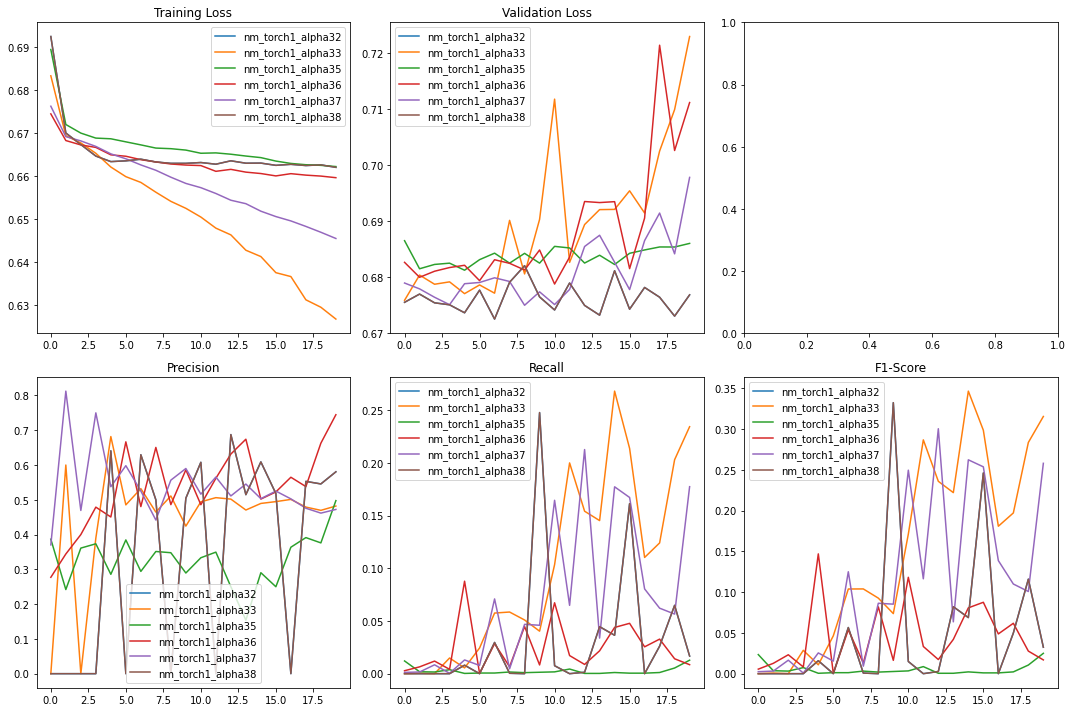

In [4]:
import matplotlib.pyplot as plt

model_ids=[
    #'alpha1',
    #'alpha2',
    #'alpha3',
    #'alpha4',  # Data = 20210726
    #'alpha5',  # Data = 20210726
    #'alpha6',  # Data = 20210726
    #'alpha7',  # Data = 20210729a
    #'alpha8',  # Data = 20210801f
    #'alpha9',  # Data = 20210801f
    #'alpha10',  # Data = 20210801f - 
    #'alpha11',  # Data = 20210801f - CustomScaler1
    #'alpha12',  # Data = 20210801f - CustomScaler1
    #'alpha13',  # Data = 20210801f - NNModelEx
    #'alpha14',
    #'alpha15',
    #'alpha16',
    #'alpha17',
    #'alpha18',
    #'alpha19',
    #'alpha20',  # Data = 20210806i - CustomScaler2
    #'alpha21',
    #'alpha22',
    #'alpha23',
    #'alpha24',
    #'alpha25',
    #'alpha26',
    #'alpha27',
    #'alpha28',
    #'alpha29',
    #'nm_torch1_alpha30',
    #'nm_torch1_alpha31',
    'nm_torch1_alpha32',
    'nm_torch1_alpha33',
    #'nm_torch1_alpha34',
    'nm_torch1_alpha35',
    'nm_torch1_alpha36',
    'nm_torch1_alpha37',
    'nm_torch1_alpha38',
]

fig,ax = plt.subplots(2,3,figsize=(15,10))
ax[0][0].set_title("Training Loss")
ax[0][1].set_title("Validation Loss")
ax[1][0].set_title("Precision")
ax[1][1].set_title("Recall")
ax[1][2].set_title("F1-Score")

limit=50

model_configs = []
model_data = {}

for model_id in model_ids:
    with open(f'models/{model_id}.cfg') as f:
        config = json.load(f)

    model_configs.append(config)
    _, _, mean_losses = load_model_only(config)

    metrics = list(zip(*mean_losses))
    tl = metrics[0]
    vl = metrics[1]
    p = metrics[2] if len(metrics)>2 else None
    r = metrics[3] if len(metrics)>3 else None
    f = metrics[4] if len(metrics)>4 else None
    
    model_data[model_id] = {'tl':tl, 'vl':vl, 'p':p, 'r':r, 'f':f}

    ax[0][0].plot(tl[:limit], label=model_id)
    ax[0][1].plot(vl[:limit], label=model_id)
    if p is not None:
        ax[1][0].plot(p[:limit], label=model_id)
    if r is not None:
        ax[1][1].plot(r[:limit], label=model_id)
    if f is not None:
        ax[1][2].plot(f[:limit], label=model_id)

# ax1.set_ylim(0,0.02)
#ax[0][1].set_ylim(0.5,2.5)
# ax1.set_yscale('log')
# ax2.set_yscale('log')

ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend()
ax[1][1].legend()
ax[1][2].legend()
plt.tight_layout()
plt.show()

In [5]:
df = pd.DataFrame(model_configs).set_index('model_identifier')
print(df.loc['nm_torch1_alpha32','optimizer'])
print(df.loc['nm_torch1_alpha38','optimizer'])
df

{'type': 'AdamW', 'lr': 0.03, 'weight_decay': 0.09, 'momentum': 0.9}
{'type': 'AdamW', 'lr': 0.03, 'weight_decay': 0.09, 'momentum': 0.9}


,model_path,model_type,data,note,device,random_seed,max_epochs,do_validate,model_width,loss,optimizer,train_params,test_params
model_identifier,,,,,,,,,,,,,
nm_torch1_alpha32,./models,ResNet28 - CustomScaler2,20210806i,,cuda,0,20,True,128,{'pos_weight': 1},"{'type': 'AdamW', 'lr': 0.03, 'weight_decay': ...","{'batch_size': 1000, 'shuffle': True, 'num_wor...","{'batch_size': 200000, 'num_workers': 5, 'pin_..."
nm_torch1_alpha33,./models,ResNet28 - CustomScaler2,20210806i,,cuda,0,20,True,128,{'pos_weight': 1},"{'type': 'AdamW', 'lr': 0.006, 'weight_decay':...","{'batch_size': 1000, 'shuffle': True, 'num_wor...","{'batch_size': 200000, 'num_workers': 5, 'pin_..."
nm_torch1_alpha35,./models,ResNet28,20210806i,disabled scaler,cuda,0,20,True,32,{'pos_weight': 1},"{'type': 'AdamW', 'lr': 0.001, 'weight_decay':...","{'batch_size': 1000, 'shuffle': True, 'num_wor...","{'batch_size': 200000, 'num_workers': 5, 'pin_..."
nm_torch1_alpha36,./models,ResNet28,20210806i,disabled scaler,cuda,0,20,True,32,{'pos_weight': 1},"{'type': 'AdamW', 'lr': 0.006, 'weight_decay':...","{'batch_size': 1000, 'shuffle': True, 'num_wor...","{'batch_size': 200000, 'num_workers': 5, 'pin_..."
nm_torch1_alpha37,./models,ResNet28,20210806i,re-enabled scaler,cuda,0,20,True,32,{'pos_weight': 1},"{'type': 'AdamW', 'lr': 0.006, 'weight_decay':...","{'batch_size': 1000, 'shuffle': True, 'num_wor...","{'batch_size': 200000, 'num_workers': 5, 'pin_..."
nm_torch1_alpha38,./models,ResNet28,20210806i,Moved scaler,cuda,0,20,True,128,{'pos_weight': 1},"{'type': 'AdamW', 'lr': 0.03, 'weight_decay': ...","{'batch_size': 1000, 'shuffle': True, 'num_wor...","{'batch_size': 200000, 'num_workers': 5, 'pin_..."


# Precision Analysis

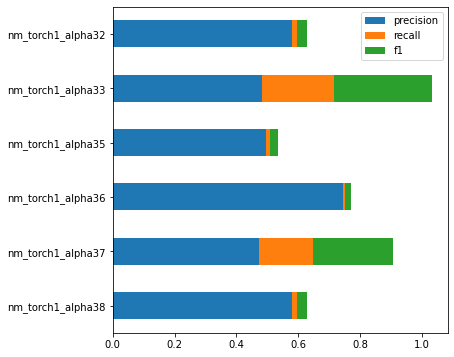

In [6]:
from sklearn.metrics import f1_score, precision_score, recall_score

precision = {}
recall = {}
f1score = {}

for model_id in model_ids:
    with open(f'models/{model_id}.cfg') as f:
        config = json.load(f)

    _, _, mean_losses = load_model_only(config)

    metrics = list(zip(*mean_losses))
    p = metrics[2][-1] if len(metrics)>2 else 0
    r = metrics[3][-1] if len(metrics)>3 else 0
    f = metrics[4][-1] if len(metrics)>4 else 0
    
    precision[model_id] = round(p,4)
    recall[model_id] = round(r,4)
    f1score[model_id] = round(f,4)
    
metrics = pd.DataFrame({k: [v,recall[k],f1score[k]] for k,v in precision.items()}, index=['precision','recall','f1']).T
metrics.plot(kind='barh', stacked=True, figsize=(6,len(metrics)))
torch.cuda.empty_cache()
plt.gca().invert_yaxis()
plt.show()

# Analyze Specific Model Results

In [7]:
# pd.DataFrame(model_data['alpha17'])

# Load and Clean Data

In [8]:
# def train_test_split(X, y, train_idx=None, test_idx=None):
#     X_train = X.loc[train_idx]
#     y_train = y.loc[train_idx]
#     X_test = X.loc[test_idx]
#     y_test = y.loc[test_idx]
#     return (X_train, y_train, X_test, y_test)

# def load_split_data(suffix, split=False):
#     X = pd.read_pickle(f'../data/X_{suffix}.pkl')
#     y = pd.read_pickle(f'../data/y_{suffix}.pkl')
#     if split:
#         X_train, y_train, X_test, y_test = train_test_split(X, y, X.loc['2018':'2020'].index, X.loc['2021':].index)
#         return X_train, y_train, X_test, y_test
#     else:
#         return X, y
    
# X_train, y_train, X_test, y_test = load_split_data(suffix='20210726', split=True)

### Same as above but runs predictions

In [9]:
# from sklearn.metrics import f1_score, precision_score, recall_score

# def get_metrics(model_id, X_test, y_test):
#     with open(f'models/{model_id}.cfg') as f:
#         config = json.load(f)

#     model, scaler, _ = load_model_only(config)
    
#     if scaler is not None:
#         X = scaler.transform(X_test.copy())
#         scaled_X = X.copy()
#     else:
#         X = X_test
    
#     predictions = predict(model, X, y_test, device=config['device'], silent=True)
#     predictions = np.nan_to_num(predictions)
    
#     precision = precision_score(y_test, predictions, zero_division=0)
#     recall = recall_score(y_test, predictions, zero_division=0)
#     f1score = f1_score(y_test, predictions, zero_division=0)
#     return precision, recall, f1score, predictions

# precision = {}
# recall = {}
# f1score = {}   

# for model_id in model_ids:
#     p, r, f, _ = get_metrics(model_id, X_test, y_test)
    
#     precision[model_id] = round(p,4)
#     recall[model_id] = round(r,4)
#     f1score[model_id] = round(f,4)

# metrics = pd.DataFrame({k: [v,recall[k],f1score[k]] for k,v in precision.items()}, index=['precision','recall','f1']).T
# metrics.plot(kind='barh', stacked=True, figsize=(6,len(metrics)))
# torch.cuda.empty_cache()
# plt.gca().invert_yaxis()
# plt.show()